In [1]:
import re

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from ALLCools.plot import *
from matplotlib import patches
from matplotlib.cm import get_cmap
from matplotlib.colors import ListedColormap, Normalize

In [2]:
from matplotlib import rc
labelsize = 6
linewidth = 0.6
rc('lines', linewidth=linewidth)
rc('axes', labelsize=labelsize, linewidth=linewidth)
rc('xtick', labelsize=labelsize)
rc('ytick', labelsize=labelsize)
rc('xtick.major', width=linewidth)
rc('ytick.major', width=linewidth)
rc('xtick.minor', width=linewidth - 0.2)
rc('ytick.minor', width=linewidth - 0.2)

## Gene metadata

In [3]:
gene_meta = pd.read_csv(
    '/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz',
    sep='\t',
    index_col='gene_id')
gene_name_to_id = {v: k for k, v in gene_meta['gene_name'].items()}

tf_genes = pd.read_csv(
    '/home/hanliu/ref/TFGene/TFClass/TFClass.with_mouse_gene_id.csv',
    index_col=0)
tf_genes = set(','.join(tf_genes['EnsemblID'].dropna()).split(','))
gene_meta['is_tf'] = gene_meta.index.map(lambda i: i.split('.')[0] in tf_genes)

zfp_pattern = r'Zfp\d+'
p = re.compile(zfp_pattern)
gene_meta.loc[gene_meta['gene_name'].apply(lambda i: p.search(i) is not None
                                           ), 'is_tf'] = True
tf_gene_names = set(gene_meta[gene_meta['is_tf']]['gene_name'].tolist())

In [4]:
remove_gene_pattern = r'(Gm\d+)|(.+Rik)'
p = re.compile(remove_gene_pattern)

keep_gene = gene_meta[
    gene_meta['gene_name'].apply(lambda i: p.search(i) is None)].index

## Cell Tidy Data

In [5]:
cell_tidy_data = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ClusteringSummary/Summary/TotalClusteringResults.msg'
)
cell_tidy_data = cell_tidy_data[cell_tidy_data['CellClass'] == 'Exc']
cell_tidy_data = cell_tidy_data[
    cell_tidy_data['SubType'].apply(lambda i: 'Outlier' not in i)].copy()

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
subtype_palette = pd.read_csv(
    '/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_type.palette.csv',
    header=None,
    index_col=0,
    squeeze=True).to_dict()

## Tree and gene assignment

In [7]:
dendro = joblib.load(
    f'/home/hanliu/project/mouse_rostral_brain/study/ITSpatial-DissectionRegion/DMG/ITSpatial.pvclust.dendrogram.lib'
)
linkage = pd.read_csv(
    f'/home/hanliu/project/mouse_rostral_brain/study/ITSpatial-DissectionRegion/DMG/ITSpatial.pvclust.linkage.csv',
    header=0,
    index_col=0)
node_dict = joblib.load(
    '/home/hanliu/project/mouse_rostral_brain/study/ITSpatial-DissectionRegion/DMG/ITSpatial.pvclust.non_singleton_node_dict.lib'
)

gene_assignment = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ITSpatial-DissectionRegion/DMG/NodeGeneResults.msg'
)
gene_assignment = gene_assignment.loc[:,
                                      gene_assignment.columns.isin(keep_gene
                                                                   )].copy()
gene_assignment.columns = gene_assignment.columns.map(gene_meta['gene_name'])

In [8]:
gene_assignment = gene_assignment[gene_assignment.index >= 142].copy()
gene_assignment.tail()

,Ptprk,Camk2g,Sardh,Mgat4c,Cpm,Tiam2,Plau,Vav2,Reep3,Grb10,...,AC157784.1,AC131065.4,CT009536.1,AC132307.2,AC152452.1,AC171003.1,AC163685.1,AC125126.1,AL929073.1,Gpr52
142,0.003663,0.000000,0.003663,0.00000,0.000000,0.014652,-0.003663,0.029304,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,-0.043956,0.366300,0.000000,0.318681,0.000000,0.021978
143,0.000000,0.026455,0.000000,0.00000,0.000000,-0.230159,0.000000,0.510582,0.000000,0.002646,...,0.026455,0.000000,0.000000,0.018519,0.507937,0.015873,0.029101,0.037037,-0.470899,-0.010582
144,0.000000,0.011312,0.021116,-0.02187,0.001508,-0.046003,-0.000754,0.122926,0.010558,-0.239065,...,-0.367270,-0.039216,0.008296,0.000000,0.210407,0.069382,-0.002262,0.008296,0.013575,0.021116


In [9]:
tf_gene_assignment = gene_assignment.loc[:,
                                         gene_assignment.columns.
                                         isin(tf_gene_names)]
other_gene_assignment = gene_assignment.loc[:, ~gene_assignment.columns.
                                            isin(tf_gene_names)]

## Normalize linkage height to 0-1

In [10]:
linkage['2'] = linkage['2'] / linkage['2'].max()

## Plot

In [11]:
rs_abs_min = 0.3

records = tf_gene_assignment.unstack().reset_index()
records.columns = ['gene', 'node', 'relevant_score']
use_data = records[records['relevant_score'].abs() > rs_abs_min].reset_index(
    drop=True)
use_data['relevant_score_abs'] = use_data['relevant_score'].abs()

n_leaves = len(dendro['ivl'])
node_height = linkage['2'].copy()
node_height.index = node_height.index
use_data['node_height'] = use_data['node'].map(node_height).reset_index(
    drop=True)
use_data.head()
print(use_data.shape)

use_data['impact'] = use_data['relevant_score_abs'] * use_data['node_height']
total_rs_data = use_data.groupby('gene')['impact'].sum().sort_values()

tf_total_data = use_data
tf_sum_rs = total_rs_data

(72, 5)


In [12]:
records = other_gene_assignment.unstack().reset_index()
records.columns = ['gene', 'node', 'relevant_score']
use_data = records[records['relevant_score'].abs() > rs_abs_min].reset_index(
    drop=True)
use_data['relevant_score_abs'] = use_data['relevant_score'].abs()

n_leaves = len(dendro['ivl'])
node_height = linkage['2'].copy()
node_height.index = node_height.index
use_data['node_height'] = use_data['node'].map(node_height).reset_index(
    drop=True)
use_data.head()
print(use_data.shape)

use_data['impact'] = use_data['relevant_score_abs'] * use_data['node_height']
total_rs_data = use_data.groupby('gene')['impact'].sum().sort_values()

other_total_data = use_data
other_sum_rs = total_rs_data

(1006, 5)


In [13]:
from adjustText import adjust_text

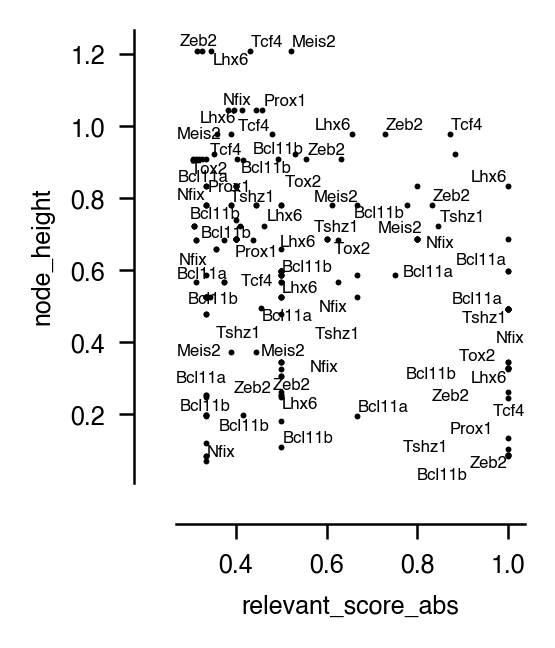

In [14]:
fig, ax = plt.subplots(figsize=(1.5, 2), dpi=300)

sns.scatterplot(data=use_data,
                ax=ax,
                s=2,
                color='k',
                linewidth=0,
                x='relevant_score_abs',
                y='node_height')

texts = []
plot_names = use_data['gene'].value_counts()[:10].index
for _, row in use_data.iterrows():
    if row['gene'] not in plot_names:
        continue
    t = ax.text(row['relevant_score_abs'],
                row['node_height'],
                row['gene'],
                ha='center',
                va='center',
                fontsize=4)
    texts.append(t)

adjust_text(texts)

sns.despine(ax=ax, offset=10)

## TF genes

In [14]:
(tf_sum_rs / len(node_dict)).sort_values(ascending=False)[:12]

gene
Rorb      0.022188
Rora      0.019593
Nr4a3     0.019096
Lhx2      0.017636
Foxp1     0.017266
Glis3     0.017044
Zfp598    0.016838
Satb1     0.016238
Tox       0.014667
Cux2      0.013889
Cux1      0.013878
Meis2     0.013224
Name: impact, dtype: float64

In [15]:
tf_sum_rs[tf_sum_rs > 0.05]

gene
Barx2      0.260710
Zfp710     0.295862
Jdp2       0.315988
Foxo1      0.321246
Asic2      0.336873
Prox1      0.337858
Nfatc2     0.339236
Zfp804a    0.341806
Zbtb16     0.355204
Pou6f2     0.360483
Bcl6       0.372025
Bhlhe22    0.377785
Stat5b     0.383861
Bach2      0.385495
Zhx1       0.389894
Irf9       0.393205
Thrb       0.426615
Foxo3      0.427682
Emx1       0.457454
Nfib       0.492128
Zfp608     0.495057
Kcnh4      0.541478
Tcf4       0.557683
Zfp385b    0.645151
Etv5       0.666667
Smad1      0.667887
Tshz3      0.669836
Fosl2      0.686181
Hivep1     0.694657
Zfhx4      0.703262
Pparg      0.703620
Grhl1      0.748115
Klf12      0.757379
Zhx2       0.787990
Etv1       0.798776
Etv6       0.813646
Rfx3       0.862121
Zfp462     0.914781
Trps1      0.925048
Elmsan1    0.933192
Meis2      0.952120
Cux1       0.999246
Cux2       1.000000
Tox        1.055999
Satb1      1.169140
Zfp598     1.212357
Glis3      1.227166
Foxp1      1.243146
Lhx2       1.269797
Nr4a3      1.37

In [16]:
tf_sum_rs.sort_values(ascending=False)[-30:]

gene
Zfhx4      0.703262
Hivep1     0.694657
Fosl2      0.686181
Tshz3      0.669836
Smad1      0.667887
Etv5       0.666667
Zfp385b    0.645151
Tcf4       0.557683
Kcnh4      0.541478
Zfp608     0.495057
Nfib       0.492128
Emx1       0.457454
Foxo3      0.427682
Thrb       0.426615
Irf9       0.393205
Zhx1       0.389894
Bach2      0.385495
Stat5b     0.383861
Bhlhe22    0.377785
Bcl6       0.372025
Pou6f2     0.360483
Zbtb16     0.355204
Zfp804a    0.341806
Nfatc2     0.339236
Prox1      0.337858
Asic2      0.336873
Foxo1      0.321246
Jdp2       0.315988
Zfp710     0.295862
Barx2      0.260710
Name: impact, dtype: float64

In [17]:
tf_sum_rs.size, other_sum_rs.size

(52, 755)

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


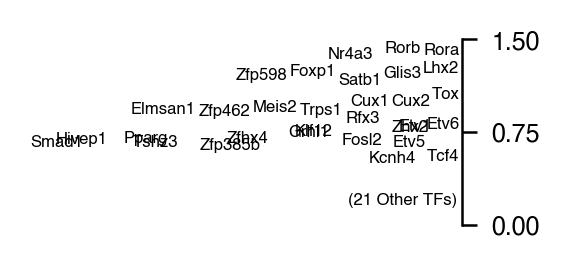

In [18]:
from matplotlib import patches
import numpy as np

label_y_cutoff = 0.5

df = tf_sum_rs[tf_sum_rs > label_y_cutoff]
other_count = tf_sum_rs[tf_sum_rs <= label_y_cutoff].size
df[f'({other_count} Other TFs)'] = 0.2

# c=[groupColors.get(langnameGroup[label],'k') for label in df.index]
fig = plt.figure(figsize=(2, 1), dpi=300)
gs = fig.add_gridspec(1, 10)

ax = fig.add_subplot(gs[0, :])
# ax_scatter = fig.add_subplot(gs[0, 9:])

ax.axes.get_xaxis().set_visible(False)
ax.set_xlim(-40, 0.1)
ax.set_ylim(0, 1.5)
ax.set_yticks([0, 0.75, 1.5])

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_label_position('right')
ax.yaxis.set_ticks_position('right')

plt.tight_layout()

patch = patches.Rectangle((-0.1, 0), 0.2, 100, fill=False, alpha=0)
# We add a rectangle to make sure the labels don't move to the right
ax.add_patch(patch)

texts = []
np.random.seed(0)
for label, y in zip(df.index, df):
    texts += [
        ax.text(
            -.1 + np.random.random() / 1000,
            y + np.random.random() / 1000,
            label,
            # A small random shift prevents labels
            # which have exactly the same coordinates from being stuck together
            # (not a problem in this example really, but wanted to mention this possibility)
            color='k',
            fontsize=4)
    ]
adjust_text(
    texts,
    [0 for _ in df],
    df,
    ha='left',
    va='center',
    add_objects=[patch],
    expand_text=(1.05, 1),
    # We want them to be quite compact, so reducing expansion makes sense
    force_text=(0.75, 0),
    force_objects=(1, 0),
    #With default forces it takes a very long time to converge,
    # but higher values still produce very nice output
    autoalign=False,
    only_move={
        'points': 'x',
        'text': 'x',
        'objects': 'x'
    })

fig.savefig('Layer.TF.total_rs.strip_plot.text_part.pdf', bbox_inches='tight')

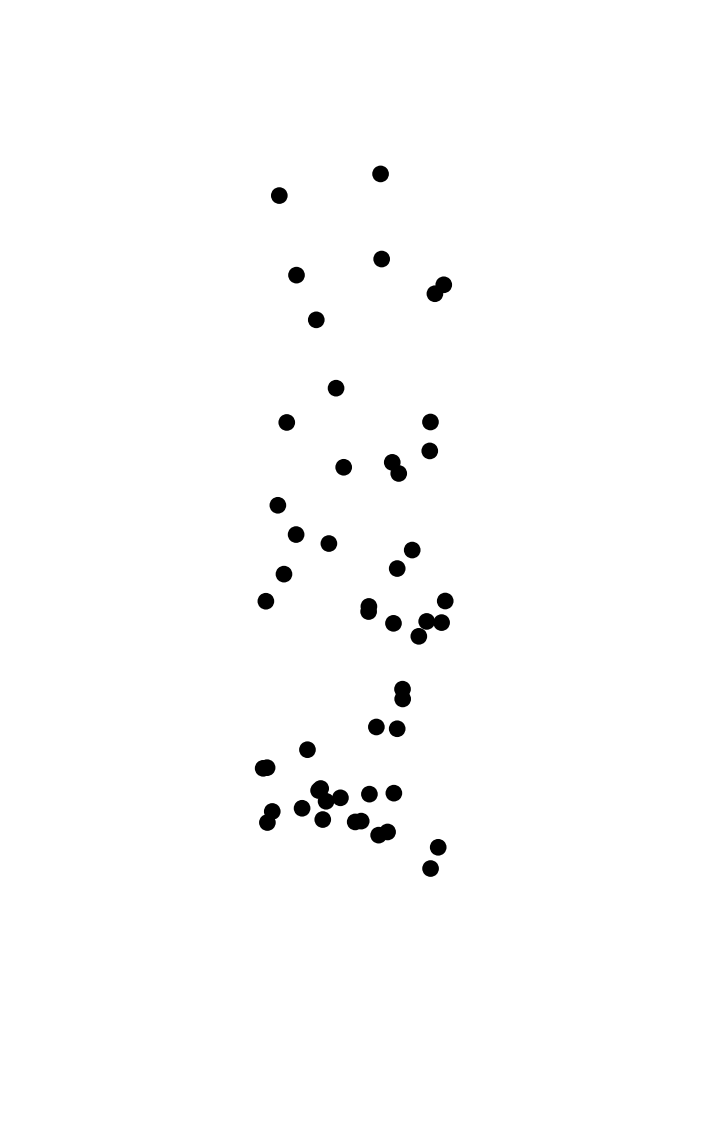

In [26]:
fig, ax = plt.subplots(figsize=(0.5, 1), dpi=1200)
sns.stripplot(y=tf_sum_rs, jitter=0.2, s=1, color='k')
ax.set(ylim=(0, 1.5))
ax.axis('off')

fig.savefig('Layer.TF.total_rs.strip_plot.scatter_part.png')

## Other genes

In [20]:
other_sum_rs.describe()

count    755.000000
mean       0.669754
std        0.358025
min        0.240205
25%        0.372597
50%        0.556573
75%        0.884497
max        1.885387
Name: impact, dtype: float64

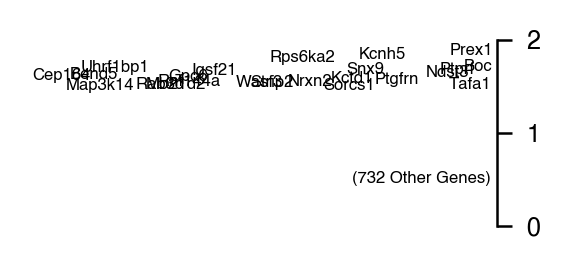

In [21]:
from matplotlib import patches
import numpy as np

label_y_cutoff = 1.5

df = other_sum_rs[other_sum_rs > label_y_cutoff]
other_count = other_sum_rs[other_sum_rs <= label_y_cutoff].size
df[f'({other_count} Other Genes)'] = 0.5

# c=[groupColors.get(langnameGroup[label],'k') for label in df.index]
fig = plt.figure(figsize=(2, 1), dpi=300)
gs = fig.add_gridspec(1, 10)

ax = fig.add_subplot(gs[0, :])
# ax_scatter = fig.add_subplot(gs[0, 9:])

ax.axes.get_xaxis().set_visible(False)
ax.set_xlim(-40, 0.1)
ax.set_ylim(0, 2)

ax.set_yticks([0, 1, 2])

ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_label_position('right')
ax.yaxis.set_ticks_position('right')

plt.tight_layout()

patch = patches.Rectangle((-0.1, 0), 0.2, 100, fill=False, alpha=0)
# We add a rectangle to make sure the labels don't move to the right
ax.add_patch(patch)

texts = []
np.random.seed(0)
for label, y in zip(df.index, df):
    texts += [
        ax.text(
            -.1 + np.random.random() / 1000,
            y + np.random.random() / 1000,
            label,
            # A small random shift prevents labels
            # which have exactly the same coordinates from being stuck together
            # (not a problem in this example really, but wanted to mention this possibility)
            color='k',
            fontsize=4)
    ]
adjust_text(
    texts,
    [0 for _ in df],
    df,
    ha='left',
    va='center',
    add_objects=[patch],
    expand_text=(1.05, 1),
    # We want them to be quite compact, so reducing expansion makes sense
    force_text=(0.75, 0),
    force_objects=(1, 0),
    #With default forces it takes a very long time to converge,
    # but higher values still produce very nice output
    autoalign=False,
    only_move={
        'points': 'x',
        'text': 'x',
        'objects': 'x'
    })

fig.savefig('Layer.Other.total_rs.strip_plot.label_part.pdf', bbox_inches='tight')

In [22]:
other_sum_rs.max()

1.8853869466881115

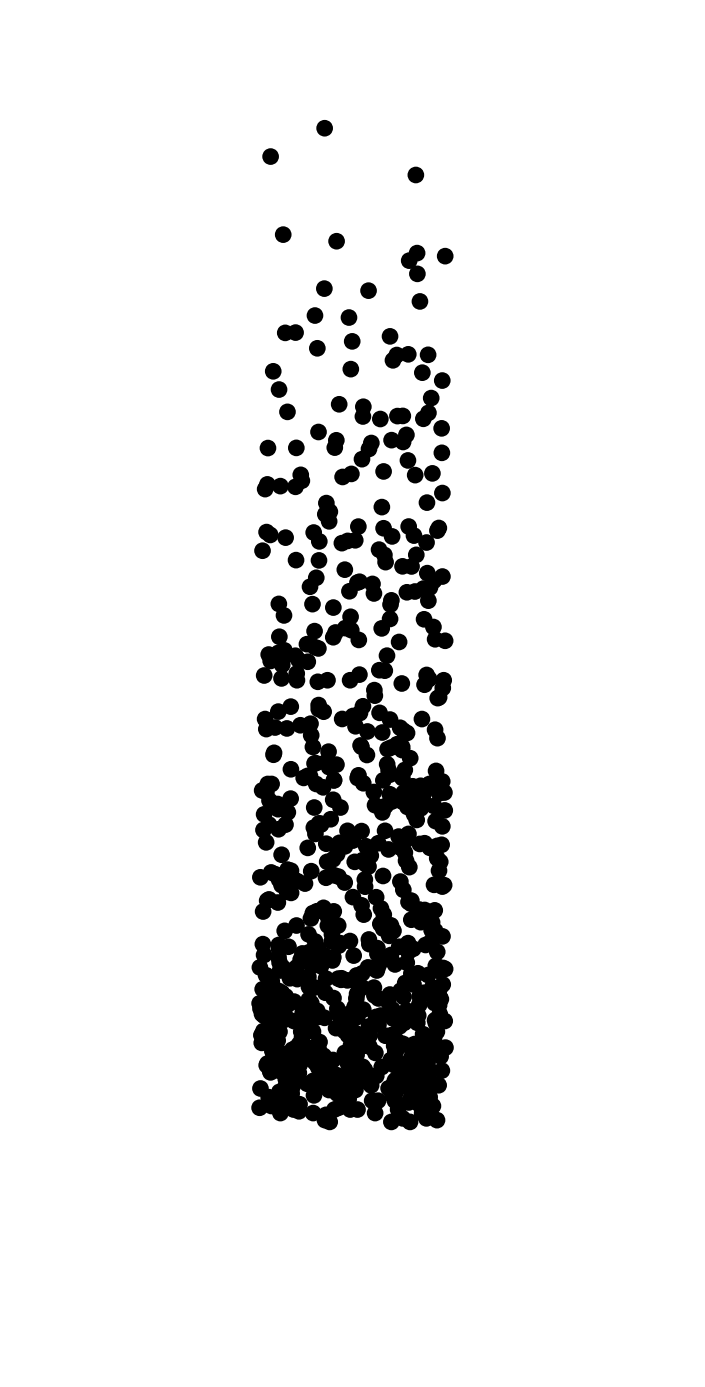

In [25]:
fig, ax = plt.subplots(figsize=(0.5, 1), dpi=1200)

sns.stripplot(y=other_sum_rs, jitter=0.2, s=1, color='k', clip_on=False)
ax.set_ylim(0, 1.5)
ax.set_xticks([])
ax.axis('off')

fig.savefig('Layer.Other.total_rs.strip_plot.scatter_part.png')

In [24]:
tf_sum_rs.to_csv('Layer.TF.sum_rs.csv', header=False)
other_sum_rs.to_csv('Layer.Other.sum_rs.csv', header=False)